In [1]:
! pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devshah2021","key":"7ca39cb5f414dd2979e6b8aa38f5f8dd"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d sonalishanbhag/online-student-concentration-analyzer

 94% 393M/417M [00:04<00:00, 95.4MB/s]
100% 417M/417M [00:04<00:00, 99.1MB/s]


In [7]:
! unzip /content/online-student-concentration-analyzer.zip

Streaming output truncated to the last 5000 lines.
  inflating: eye-direction/train/left/left_(619).png  
  inflating: eye-direction/train/left/left_(620).jpg  
  inflating: eye-direction/train/left/left_(620).png  
  inflating: eye-direction/train/left/left_(621).jpg  
  inflating: eye-direction/train/left/left_(621).png  
  inflating: eye-direction/train/left/left_(622).jpg  
  inflating: eye-direction/train/left/left_(622).png  
  inflating: eye-direction/train/left/left_(623).jpg  
  inflating: eye-direction/train/left/left_(623).png  
  inflating: eye-direction/train/left/left_(624).jpg  
  inflating: eye-direction/train/left/left_(624).png  
  inflating: eye-direction/train/left/left_(625).jpg  
  inflating: eye-direction/train/left/left_(625).png  
  inflating: eye-direction/train/left/left_(626).jpg  
  inflating: eye-direction/train/left/left_(626).png  
  inflating: eye-direction/train/left/left_(627).jpg  
  inflating: eye-direction/train/left/left_(627).png  
  inflating: e

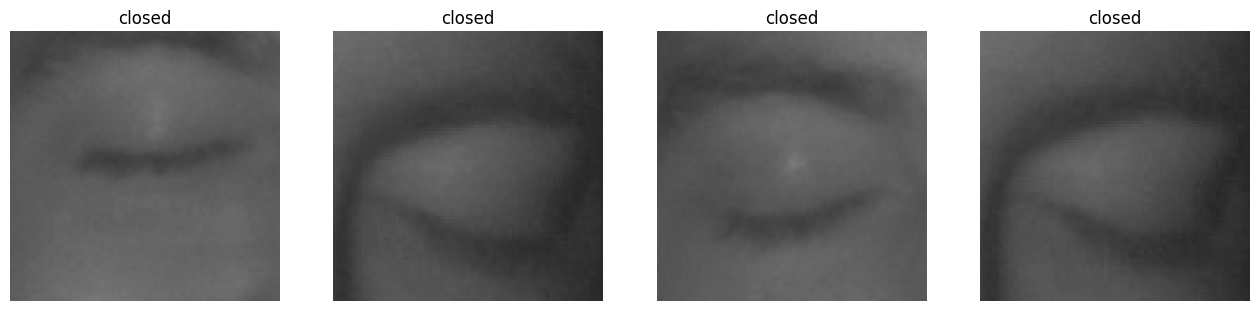

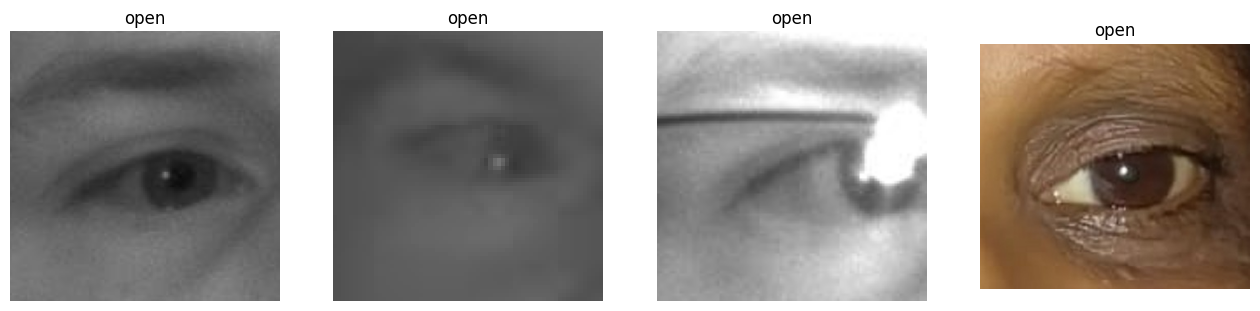

In [8]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Paths to the dataset
TRAIN_PATH = "/content/eye-detection/train/"
TEST_PATH = "/content/eye-detection/test/"

# Function to view random images from both classes
def view_random_images(path, class_name):
    plt.figure(figsize=(16, 16))

    for i in range(4):
        plt.subplot(1, 4, i + 1)

        # Corrected the path by adding a forward slash between path and class_name
        random_img = random.choice(os.listdir(path + '/' + class_name))
        img = cv2.imread(path + '/' + class_name + '/' + random_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

# Display random images from both classes
view_random_images(TRAIN_PATH, "closed")
view_random_images(TRAIN_PATH, "open")

<BarContainer object of 6 artists>

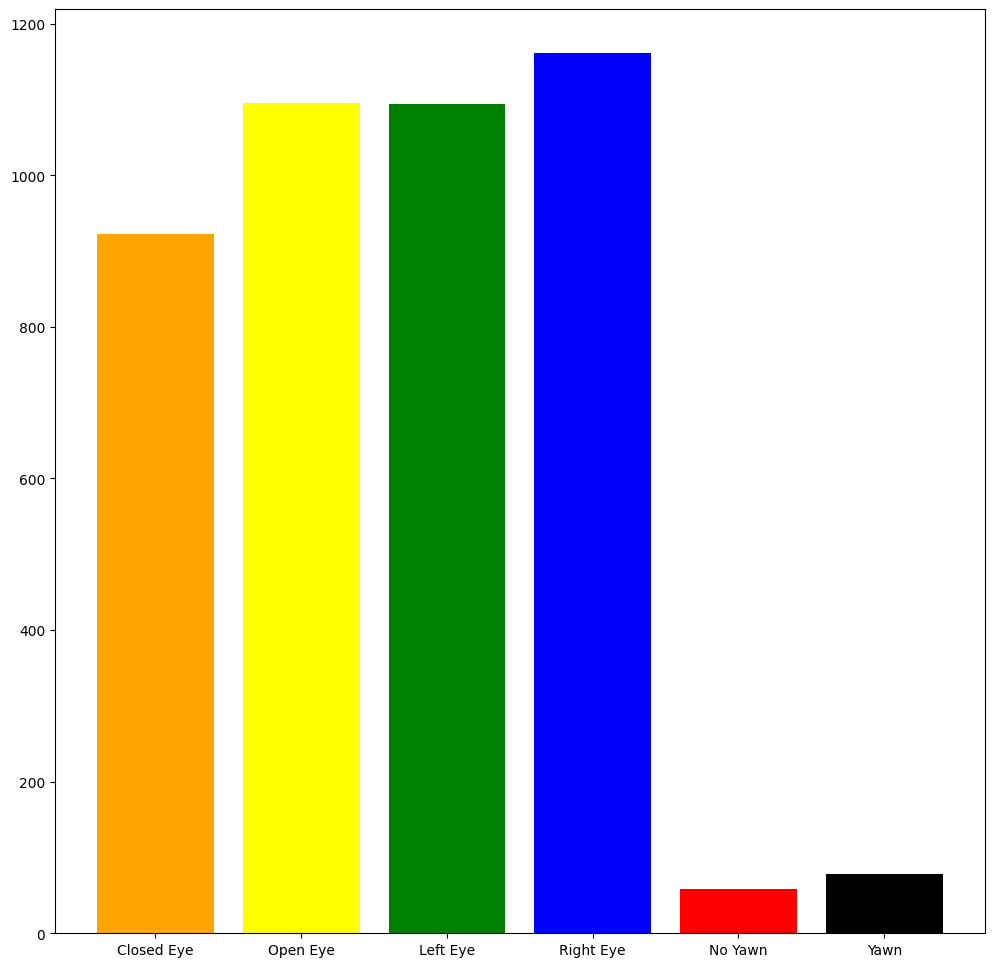

In [10]:
closed_eye = len(os.listdir('/content/eye-detection/test/closed'))
open_eye = len(os.listdir('/content/eye-detection/test/open'))
left_eye = len(os.listdir('/content/eye-direction/test/left'))
right_eye = len(os.listdir('/content/eye-direction/test/right'))
no_yawn = len(os.listdir('/content/yawn-detection/test/no_yawn'))
yawn = len(os.listdir('/content/yawn-detection/test/yawn'))

plt.figure(figsize=(12, 12))

plt.bar(["Closed Eye", "Open Eye", "Left Eye", "Right Eye", 'No Yawn', 'Yawn'],
 [closed_eye, open_eye, left_eye, right_eye, no_yawn, yawn],
        color=['orange', 'yellow', 'green', 'blue', 'red', 'black'])
